In [3]:
import numpy as np
import scipy
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import stats
from scipy import optimize
from numpy.random import default_rng

import time

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<h1>Making an NFW halo</h1>

<h2>Important equations:</h2>

mass density $\rho (r)$:
\begin{equation}
\rho (r) = \frac{\rho_o}{\frac{r}{a}\left(1+\frac{r}{a}\right)^2}
\end{equation}

total mass at radius r $M (r)$:
\begin{equation}
M (r) = 4 \pi \rho_o a^3 \left( ln\left(1+\frac{r}{a}\right) - \frac{\frac{r}{a}}{1+\frac{r}{a}}\right)
\end{equation}

potential at radius r $\Phi (r)$:
\begin{equation}
\Phi (r) = -4 \pi G \rho_o a^2 \frac{ln\left(1+\frac{r}{a}\right)}{\frac{r}{a}}
\end{equation}

We can define some distant radius $r_\Delta$ where $\rho (r_\Delta)=\Delta\cdot\rho_c$ where $\rho_c$ is the cosmological critical density and $\Delta$ is some number, usually 200. This radius $r_\Delta$ is usually quite a bit bigger than the scale radius a, and the ratio between these quantities is usually characterized by the "concentration" of the halo:
$c=\frac{r_\Delta}{a}$

<h2>Generating the radial distribution</h2>
The differential bit of mass contained in a shell of thickness dr at radius r is given by:
\begin{equation}
    dM(r) = 4\pi r^2 \rho (r) dr.
\end{equation}

Integrating this differential shell of mass up to some radius tells how much mass in enclosed in a volume up to a certain volume. Dividing by some total mass (defined by the mass enclosed at $r_\Delta$) we now have an idea of what fraction of mass is enclosed up to any radius. This is equivalent to the cumulative distribution function for the radius of tracers in the halo:
\begin{equation}
    \text{CDF(r)} = \frac{M(r)}{M(r_{200})} = \frac{\int_0^r {r'}^2 \frac{\rho_0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'} {\int_0^{r_{200}} {r'}^2 \frac{\rho_0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'}
\end{equation}

We can pick a radius at random, but that will only create a flat probability distribution in r. We need a way to systematic way to encode the bumpiness of the distribution in our random number generation. Since we can explicitly compute the CDF we can sample a better way: inverse transform sampling.

The CDF for the radii of tracers in the halo can be written in terms of nice dimensionless variables:
\begin{equation}
    \text{CDF}(\chi) = \frac{ln(1+c\chi) - \frac{c\chi}{1+c\chi}} {ln(1+c) - \frac{c}{1+c}};\:(0<\chi<1)
\end{equation}

where $\chi=\frac{r}{r_\Delta}$ and $c=\frac{r_\Delta}{a}$ (as previously defined).

In [14]:
class haloNFW(): # Our NFW halo object
    def __init__(self,nTracers,a,r_delta,rho_0,critical_density=1.26*10**-7):
        """
        NFW Halo. This init just stores some of the arguments passed in and computes some important/handy quantities.
        """
        self.nTracers = nTracers
        self.a = a
        self.r_delta = r_delta
        self.rho_0 = rho_0
        self.rho_critical = critical_density # solar masses/Mpc^3
        #c_term_1 = ((3*np.sqrt(3)*np.sqrt(27*self.rho_0**2/(self.delta*self.rho_critical)**2 
        #                                  + 4*self.rho_0/(self.delta*self.rho_critical)) 
        #             + 27*self.rho_0/(self.delta*self.rho_critical) 
        #             + 2)/2)**(1/3)
        #self.c = ( c_term_1 + 1./c_term_1 -2 )/3.
        self.c = np.float64(self.r_delta / self.a)
        self.G_SI = 6.67*10**-11 # SI Newton's constant, m^3/(kg*s^2)
        self.G = 4.5*10**-32 # Newton's constant, pc**3/(solar mass * seconds**2)
        self.G_natural = 1 # "natural" ;D
        self.M_halo = (4*np.pi*self.rho_0*self.a**3)*self.g_fcn(self.c)#(np.log(1+self.c)-(self.c/(1+self.c)))
        self.virial_speed = np.sqrt(self.G*self.M_halo/self.r_delta)
        
    def nfwPotential(self, r_norm):
        return -(4*np.pi*self.rho_0*self.a**3)*(np.log(1+self.c*r_norm)/(self.c*r_norm))
        
    def radialCDF(self,r_norm):
        """
        This is the radial cumulative distribution function for an NFW halo. Takes an un-normalized radius and spits out the probability for
        r to be between 0 and the input radius. When paired with inverse transform sampling, you can rebuild the radial distribution function
        with a small set of tracers.
        """
        if 0<=r_norm<=1:
            return self.g_fcn(self.c*r_norm)/self.g_fcn(self.c)
        else:
            print("Out of acceptable radial bounds")
    
    def randomNum(self,n=1):
        """
        Basic implementation of the new scipy random number generation. Creates a new generator and calls the .random(n) method
        which returns n random numbers uniformly distributed between 0 and 1.
        """
        return default_rng().random(n) # generates n random numbers
    
    def inverseTransformSampling(self, CDF, bracket, nSamples):
        """
        Simple implementation of inverseTransformSampling. Currently a little slow since I need to loop though each sample instead of doing it
        in one step that can be parallelized. You win some, you lose some. Anyways, this takes any cumulative distribution function (CDF), subtracts
        some random offset from it between 0 and 1, and then finds the root of that offset CDF. When you repeat this process and record the roots,
        you actually recover the original distribution function and can draw from it truly at random.
        """
        result = []
        CDFsubRandomNumber = lambda x: CDF(x) - self.randomNum(1) # Need a modified CDF where we subtract some random offset each time it's called.
        for i in range(nSamples):
            result.append( optimize.root_scalar( CDFsubRandomNumber , bracket = bracket ).root )
            
        return np.array(result)
    
    def genTracerCoords(self):
        """
        Our halo needs tracer stars, and those tracer stars need coordinates! (otherwise they wouldn't be anywhere...) You should probably avoid
        calling this function, since the calculation of velocities will actually need the list of radii this function generates. If you were to
        generate these radii, then generate velocities, but then generate radii again the velocities wouldn't update. So this should only be called
        in the genTracers() method.
        
        This defines two class properties: radii and sphericalCoordinateAngles. radii is self-explanatory, sphericalCoordinateAngles is a 2-row array where the first
        row is the list of polar angles (theta) called like sphericalCoordinateAngles[0,:] and the second row is the list of azimuthal angles (phi) called like
        sphericalCoordinateAngles[1,:].
        """
        self.radii = self.inverseTransformSampling( self.radialCDF, bracket = (0, self.r_delta), nSamples = self.nTracers)
        self.norm_radii = self.radii / self.r_delta
        self.sphericalCoordinateAngles = np.array(
            [self.randomNum(self.nTracers)*np.pi,
             self.randomNum(self.nTracers)*2*np.pi]
        ) # first row is theta, second row is phi

    def g_fcn(self,x):
        """
        Helper function since things like this turn up a lot in NFW profiles.
        """
        return np.log(1+x)-(x/(1+x))
    
    def radialVelocityDispersion(self,r_norm):
        return np.sqrt(self.virial_speed**2*\
                       ((self.c*r_norm*(1+self.c*r_norm)**2)/self.g_fcn(self.c))*\
                       integrate.quad(lambda y: self.g_fcn(y)/(y**3*(1+y)**2), self.c*r_norm, np.inf)[0]
                      )
    
    def radialVelocityPDF(self,v_radial,dispersion_squared):
        return ((3/(2*np.pi*dispersion_squared))**(3/2))*4*np.pi*v_radial**2*np.exp(-3*v_radial**2/(2*dispersion_squared))
    
    def radialVelocityCDF(self,v_radial,dispersion_squared):
        return integrate.quad( lambda v: self.radialVelocityPDF(v,dispersion_squared), 0, v_radial)[0]
    
    def plotRadialVelocityCDF(self,r_norm,steps=100):
        v = np.linspace(0,self.virial_speed,steps)
        cdf = []
        for i in range(steps):
            disp = self.radialVelocityDispersion(r_norm)
            cdf.append(self.radialVelocityCDF(v[i], disp**2))
        plt.scatter(v,cdf)
        
    def plotRadialVelocityPDF(self,r_norm,steps=100):
        v = np.linspace(0,self.virial_speed,steps)
        pdf = []
        for i in range(steps):
            disp = self.radialVelocityDispersion(r_norm)
            pdf.append(self.radialVelocityPDF(v[i], disp**2))
        plt.scatter(v,pdf)
    
    def genTracerVelocities(self):
        self.tracerRVDispersion = []
        self.radialVelocities = []
        for i in range(self.nTracers):
            disp = self.radialVelocityDispersion(self.norm_radii[i]) # Compute the radial velocity dispersion at the given radius.
            self.tracerRVDispersion.append(disp) # Store this in an array of dispersions for each tracer. Good bookkeeping.
            v_max = np.sqrt(np.abs(2*self.nfwPotential(self.norm_radii[i]))) # Kinematic limit for V. Is this right?
            self.radialVelocities.append(self.inverseTransformSampling(lambda v: self.radialVelocityCDF(v,disp), bracket = (0, v_max), nSamples = 1))
        self.sphericalVelocityAngles = np.array(
            [self.randomNum(self.nTracers)*np.pi,
             self.randomNum(self.nTracers)*2*np.pi]
        ) # first row is theta, second row is phi

    def genTracers(self):
        self.genTracerCoords()
        self.genTracerVelocities()
        self.sphericalPhaseSpacePoints = [self.radii,
                                          self.sphericalCoordinateAngles,
                                          self.radialVelocities,
                                          self.sphericalVelocityAngles]

In [15]:
# Let's make a halo!

nTracers = 1000
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec
scaleRadiusA = .01
scaleRadiusDelta = 1

halo = haloNFW(nTracers,scaleRadiusA,scaleRadiusDelta,mwHaloDensity,criticalDensity)

In [16]:
halo.genTracerCoords()

1


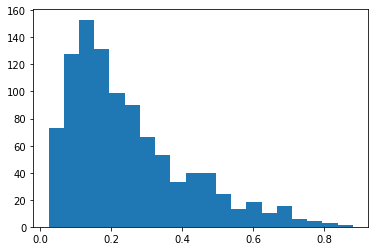

In [17]:
plt.hist(halo.radii,20)
print(halo.r_delta)

In [18]:
x = halo.radii*np.sin(halo.sphericalCoordinateAngles[0,:])*np.cos(halo.sphericalCoordinateAngles[1,:])
y = halo.radii*np.sin(halo.sphericalCoordinateAngles[0,:])*np.sin(halo.sphericalCoordinateAngles[1,:])
z = halo.radii*np.cos(halo.sphericalCoordinateAngles[0,:])

1.2131896729198108e-19

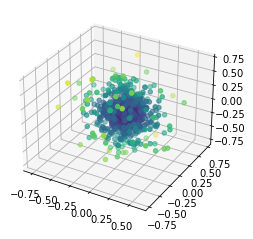

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=halo.radii)
halo.virial_speed

In [20]:
test_halo = haloNFW(1000,.01,1,1,.001)
test_halo.genTracerCoords()

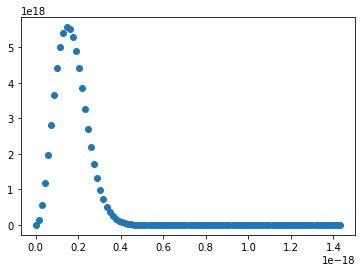

In [24]:
test_halo.plotRadialVelocityPDF(.001)

In [23]:
halo.genTracers()

ValueError: f(a) and f(b) must have different signs

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

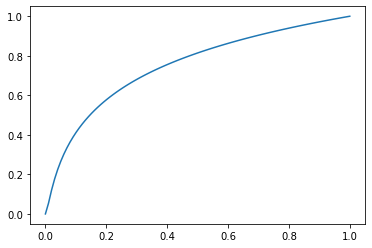

In [8]:
n=100
xlist = np.linspace(0,halo.r_delta,n)
ylist = []
print(xlist)
for i in range(n):
    ylist.append(halo.radialCDF(xlist[i]))
plt.plot(xlist,ylist)

In [9]:
np.zeros((3,2))
rng = default_rng()
default_rng().random()
A = np.array([2,3,4,5])
B = np.array([11,22,33,44])
C = np.array([A,B])

In [156]:
def test(x):
    return 2*x-1

def test_mod(x):
    return test(x) - default_rng().random(1)
optimize.root_scalar( test_mod, bracket = (-5,5) ).root

0.7577792502772075

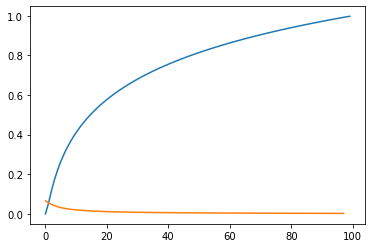

In [172]:
halo.radialCDF(.999*halo.r_delta)

CDF = []
PDF_est = []
for i in range(100):
    rad = (i/100)*halo.r_delta
    CDF.append(halo.radialCDF(rad))
    if i>1:
        PDF_est.append(CDF[i]-CDF[i-1])
    
plt.plot(CDF)
plt.plot(PDF_est)